In [1]:
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [2]:
data = pd.read_csv("DailyDelhiClimateTrain.csv")

In [3]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df = data.copy()

In [5]:
data.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

# Changement du type de la date (objet) en format datetime

In [6]:
# Changement du type de la date (objet) en format datetime

data.date= pd.to_datetime(data.date)

In [7]:
data.dtypes

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

# Valeurs manquantes

In [8]:
data.isna().sum()
# Aucune valeur manquante

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

# Duplication des données

In [9]:
data.duplicated().sum()
# Pas de données dupliquées

0

In [10]:
data.index = data['date'] 

In [11]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [12]:
data.drop(['date'],axis=1,inplace=True)

In [13]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [14]:
data2 = data["meantemp"]

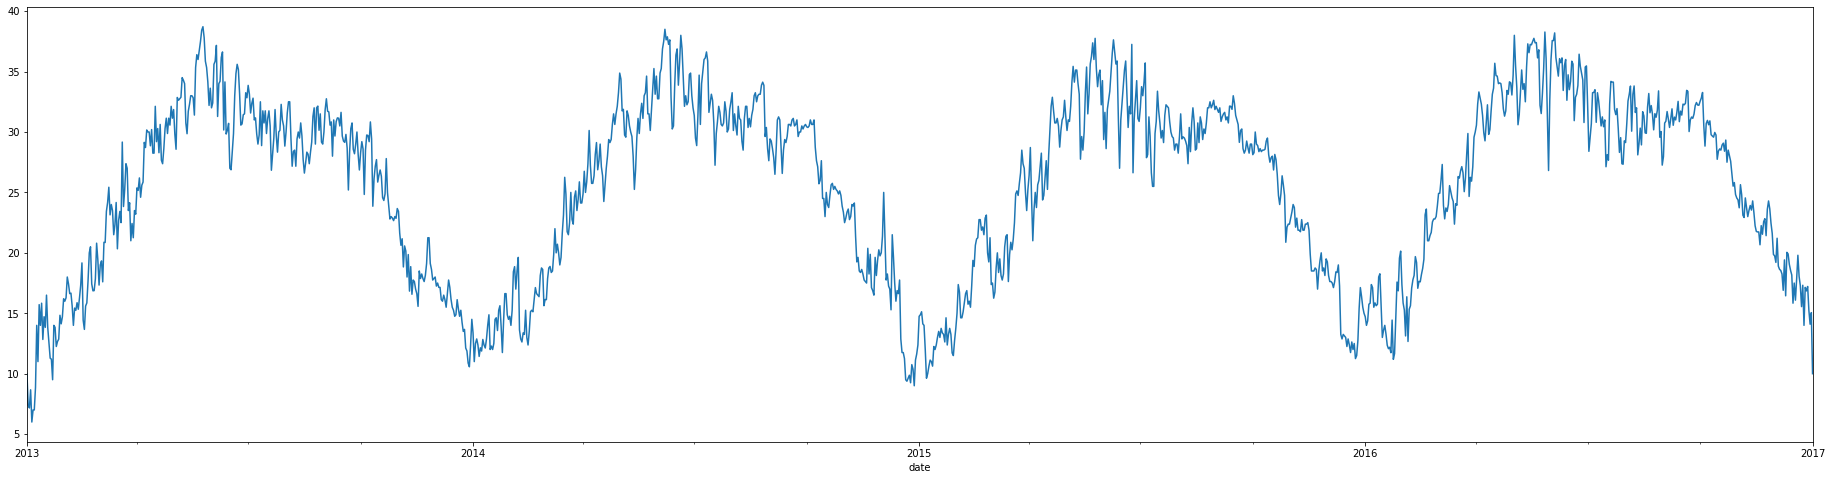

In [15]:
data2.plot(figsize=(32,8))

# 1- En utilisant la colonne de température moyenne; soit la meantemp, faites une analyse :

# Time Step (La régression de la température moyenne en fonction du temps)

In [16]:
# Create a time dummy
time = np.arange(len(df.index))

df['time'] = time 

# Create training data
X = df.loc[:,['time']]   # features
y = df.loc[:,'meantemp']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [17]:
df_pred = pd.DataFrame({"date":df["date"],"time":df["time"],"meantemp":df["meantemp"],"meantemp_prediction":y_pred})
df_pred

,date,time,meantemp,meantemp_prediction
0,2013-01-01,0,10.000000,23.836898
1,2013-01-02,1,7.400000,23.839169
2,2013-01-03,2,7.166667,23.841439
3,2013-01-04,3,8.666667,23.843710
4,2013-01-05,4,6.000000,23.845980
...,...,...,...,...
1457,2016-12-28,1457,17.217391,27.145061
1458,2016-12-29,1458,15.238095,27.147331
1459,2016-12-30,1459,14.095238,27.149602
1460,2016-12-31,1460,15.052632,27.151873


Text(0.5, 1.0, 'Time Plot of meantemp')

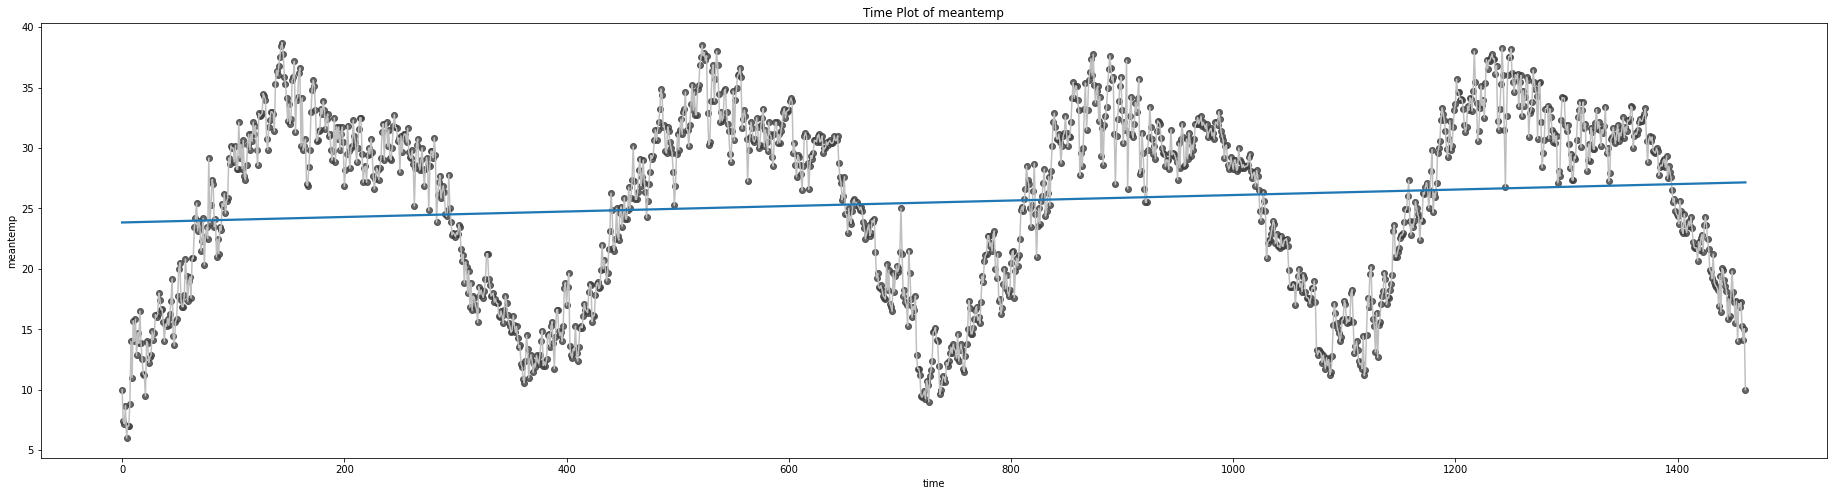

In [18]:
fig, ax = plt.subplots(figsize=(32,8))
ax.plot('time', 'meantemp', data=df, color='0.75')
ax = sns.regplot(x='time', y='meantemp', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of meantemp')

Les températures ont tendance à augmenter avec le temps.

# Lag Feature (La régression en fonction de l’instant n-1)

In [19]:
df['Lag_1'] = df['meantemp'].shift(1)
df = df.reindex(columns=['meantemp', 'Lag_1'])

df.head()

,meantemp,Lag_1
0,10.000000,NaN
1,7.400000,10.000000
2,7.166667,7.400000
3,8.666667,7.166667
4,6.000000,8.666667


L'autocorrélation avec décalage (k=1) est la corrélation avec la température d'aujourd'hui y(t) et la température d'hier y(t-1)

In [20]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature 
y = df.loc[:, 'meantemp']  
y, X = y.align(X, join='inner')  

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

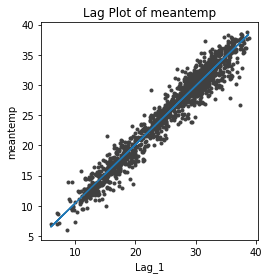

In [21]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('meantemp')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of meantemp');

Le diagramme de décalage nous montre à quel point nous avons réussi à ajuster la relation entre les températures moyennes d'une journée et les températures de la veille.

# 2- En rappliquant tous les processus vus en cours, analyser la tendance :

# Tracer des graphes de moyennes glissantes (moving average)

In [22]:
trend = data["meantemp"].rolling(window=365, center=True, min_periods=6).mean()

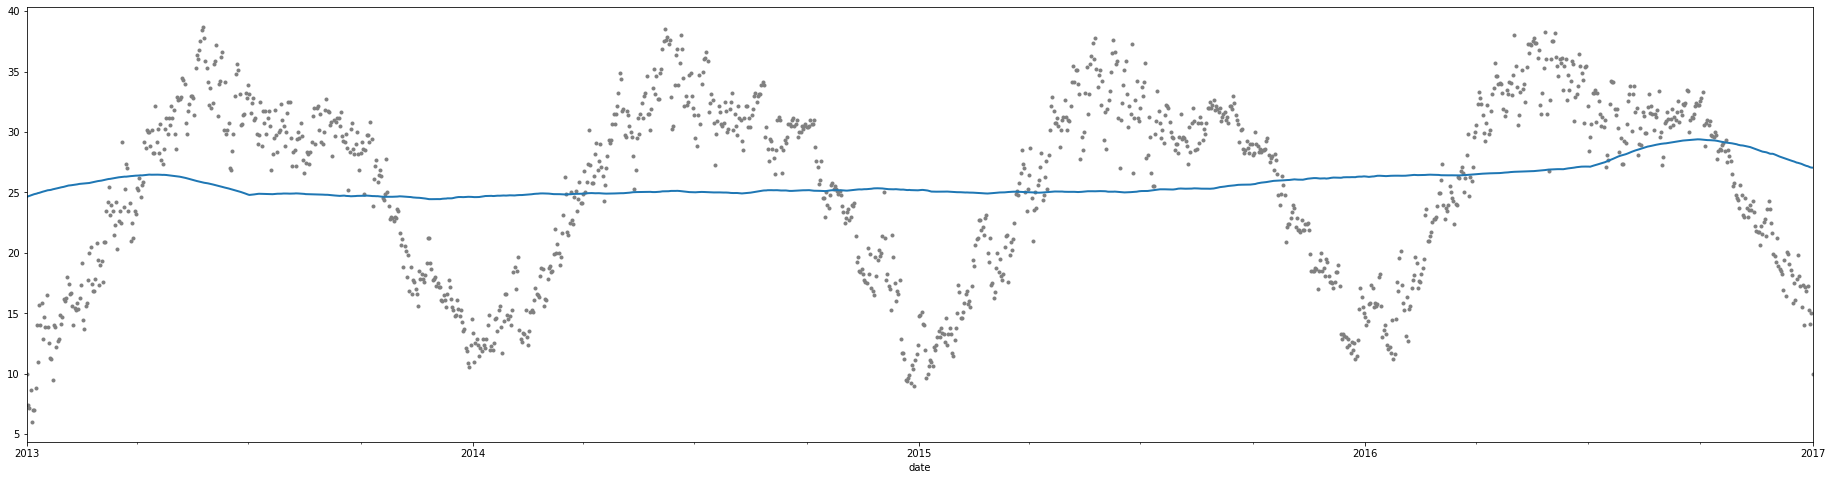

In [23]:
ax = data["meantemp"].plot(style=".", color="0.5",figsize=(32,8))
#ax = data["meantemp"].plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=2)

La tendance est légèrement à la hausse début 2013, est à la baisse jusque mi 2013, contante jusque milieu 2016 puis observe une légère hausse et baisse début 2017

# Utiliser les méthodes de Trend Engineering par le biais de la bibliothèque Deterministic Process afin de déterminer la tendance optimale.

In [24]:
from statsmodels.tsa.deterministic import DeterministicProcess

# Faire des graphe pour la tendance linéaire, quadratique, cubique. Tester pour d’autres dimensions.

# Linear 

In [25]:
dp1 = DeterministicProcess(
    index=df["meantemp"].index,  
    constant=True,       
    order=1,             # Linear
    drop=True,           
)

X = dp1.in_sample()

X.head()

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0


In [26]:
y = df["meantemp"]  

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

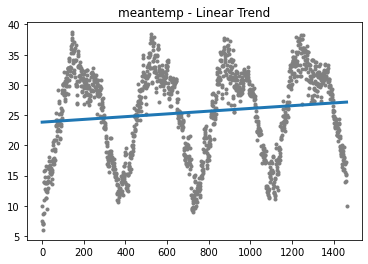

In [27]:
ax = y.plot(style=".", color="0.5", title="meantemp - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

La tendance est constante

# Quadratique

In [28]:
dp2 = DeterministicProcess(
    index=df["meantemp"].index,  
    constant=True,       
    order=2,             # quadratique
    drop=True,           
)

X = dp2.in_sample()

X.head()

,const,trend,trend_squared
0,1.0,1.0,1.0
1,1.0,2.0,4.0
2,1.0,3.0,9.0
3,1.0,4.0,16.0
4,1.0,5.0,25.0


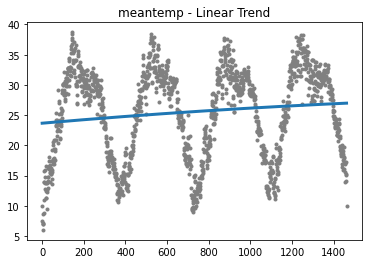

In [29]:
y = df["meantemp"]  

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", title="meantemp - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

La tendance est constante mais on observe un commencement de concavité

# Cubic

In [30]:
dp3 = DeterministicProcess(
    index=df["meantemp"].index,  
    constant=True,      
    order=3,             # cubic
    drop=True,           
)

X = dp3.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
0,1.0,1.0,1.0,1.0
1,1.0,2.0,4.0,8.0
2,1.0,3.0,9.0,27.0
3,1.0,4.0,16.0,64.0
4,1.0,5.0,25.0,125.0


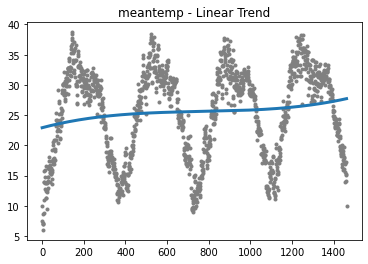

In [31]:
y = df["meantemp"]  

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", title="meantemp - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

On observe une légère concavité de la tendance

# Autre dimension: dimension 6

In [32]:
dp6 = DeterministicProcess(
    index=df["meantemp"].index,  
    constant=True,      
    order=6,             
    drop=True,           
)

X = dp6.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**5
0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,4.0,8.0,32.0
2,1.0,3.0,9.0,27.0,243.0
3,1.0,4.0,16.0,64.0,1024.0
4,1.0,5.0,25.0,125.0,3125.0


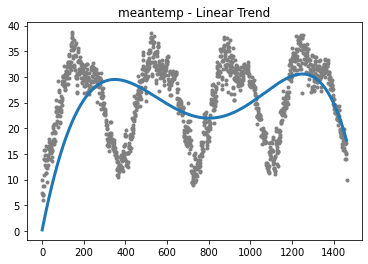

In [33]:
y = df["meantemp"]  

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", title="meantemp - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

La tendance est concave. Elle commence à suivre la saisonnalité.

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

def best_order(y, validation_set, max_order=10):
    errors_mae = []
    errors_mse = []
    
    for order in range(1, max_order + 1):
        model = AutoReg(y, lags=order)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(y), end=len(y) + len(validation_set) - 1, dynamic=False)
        errors_mae.append(mean_absolute_error(validation_set, predictions))
        errors_mse.append(mean_squared_error(validation_set, predictions))
        print("Order:", order, "MAE:", errors_mae[-1].round(3), "MSE:", errors_mse[-1], errors_mae[-1].round(3))
    
    best_order_mae = np.argmin(errors_mae) + 1
    best_order_mse = np.argmin(errors_mse) + 1
    
    return best_order_mae, best_order_mse

# Example usage
y = df["meantemp"].values
validation_set = df["meantemp"].values[-365:]
best_order_mae, best_order_mse = best_order(y, validation_set)
print("Best order (MAE):", best_order_mae)
print("Best order (MSE):", best_order_mse)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
 

Order: 1 MAE: 5.565 MSE: 41.37973579461032 5.565
Order: 2 MAE: 5.747 MSE: 44.01474677485295 5.747
Order: 3 MAE: 5.956 MSE: 47.15760250278868 5.956
Order: 4 MAE: 6.483 MSE: 55.70089373038117 6.483
Order: 5 MAE: 6.608 MSE: 57.86246815103732 6.608
Order: 6 MAE: 6.826 MSE: 61.729243957013175 6.826
Order: 7 MAE: 6.901 MSE: 63.10654473845761 6.901
Order: 8 MAE: 7.145 MSE: 67.67532913670075 7.145
Order: 9 MAE: 7.485 MSE: 74.40919075473205 7.485
Order: 10 MAE: 7.635 MSE: 77.54291650306875 7.635
Best order (MAE): 1
Best order (MSE): 1


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Selon le MAE et MSE,l'order 1 - Linéaire est le meilleur en terme de MAE et MSE

# Faire un forecast pour 15 jours futurs

In [35]:
y = df['meantemp']
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=15)

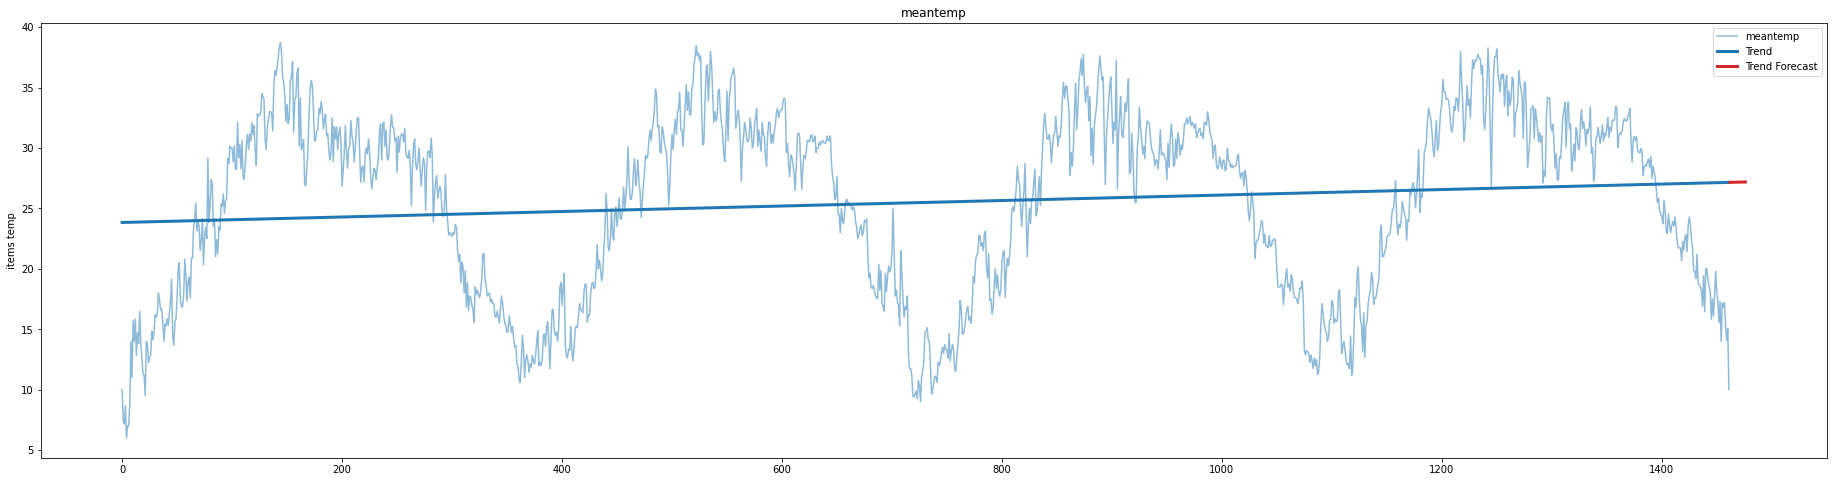

In [36]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="meantemp", ylabel="items temp",figsize=(32,8))
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [37]:
residuals = y - y_pred
df2=df
df2['residuals']=residuals
df2.head()

,meantemp,Lag_1,residuals
0,10.000000,NaN,-13.836898
1,7.400000,10.000000,-16.439169
2,7.166667,7.400000,-16.674773
3,8.666667,7.166667,-15.177043
4,6.000000,8.666667,-17.845980


#  Enlevez la composante de tendance de votre série.

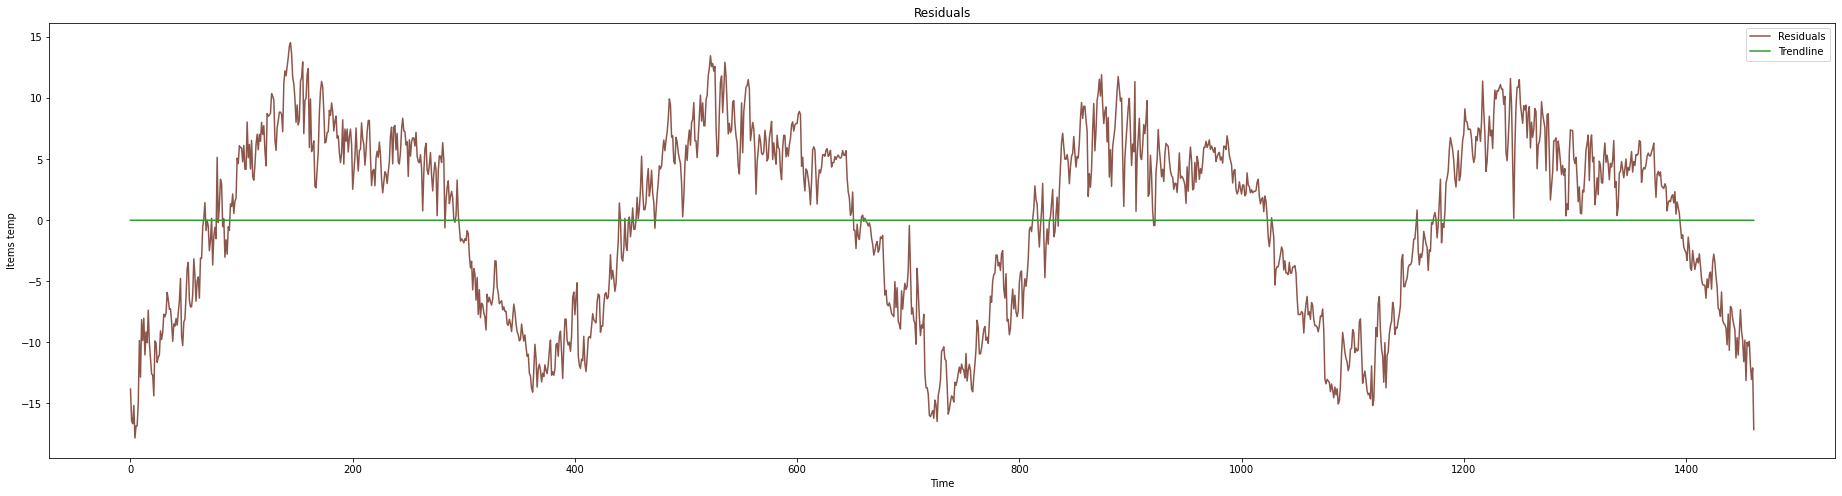

In [38]:
import matplotlib.pyplot as plt


# Fit a linear regression model to the residuals
model = LinearRegression()
model.fit(X=df2.index.to_frame(), y=residuals)

# Get the fitted line
trendline = pd.Series(model.predict(df2.index.to_frame()), index=df2.index)

# Plot the residuals and the trendline
fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(residuals, color='C5', label='Residuals')
ax.plot(trendline, color='C2', label='Trendline')
ax.legend()
ax.set_title("Residuals")
ax.set_xlabel("Time")
ax.set_ylabel("Items temp")
plt.show()
#La visualisation sans les résiduels avec la ligne de tendance qui est plat

# En réitérant les mécanismes vus en cours, étudier la saisonnalité de la série temporelle:

In [39]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [40]:
day=data.index.dayofweek.tolist()
week=data.index.week.tolist()
year=data.index.year.tolist()
dayofyear=data.index.dayofyear.tolist()
df3=pd.DataFrame()  
df3['meantemp']=data['meantemp']
df3['day']=day
df3['dayofyear']=dayofyear
df3['week']=week
df3['year']=year
df3


,meantemp,day,dayofyear,week,year
date,,,,,
2013-01-01,10.000000,1,1,1,2013
2013-01-02,7.400000,2,2,1,2013
2013-01-03,7.166667,3,3,1,2013
2013-01-04,8.666667,4,4,1,2013
2013-01-05,6.000000,5,5,1,2013
...,...,...,...,...,...
2016-12-28,17.217391,2,363,52,2016
2016-12-29,15.238095,3,364,52,2016
2016-12-30,14.095238,4,365,52,2016


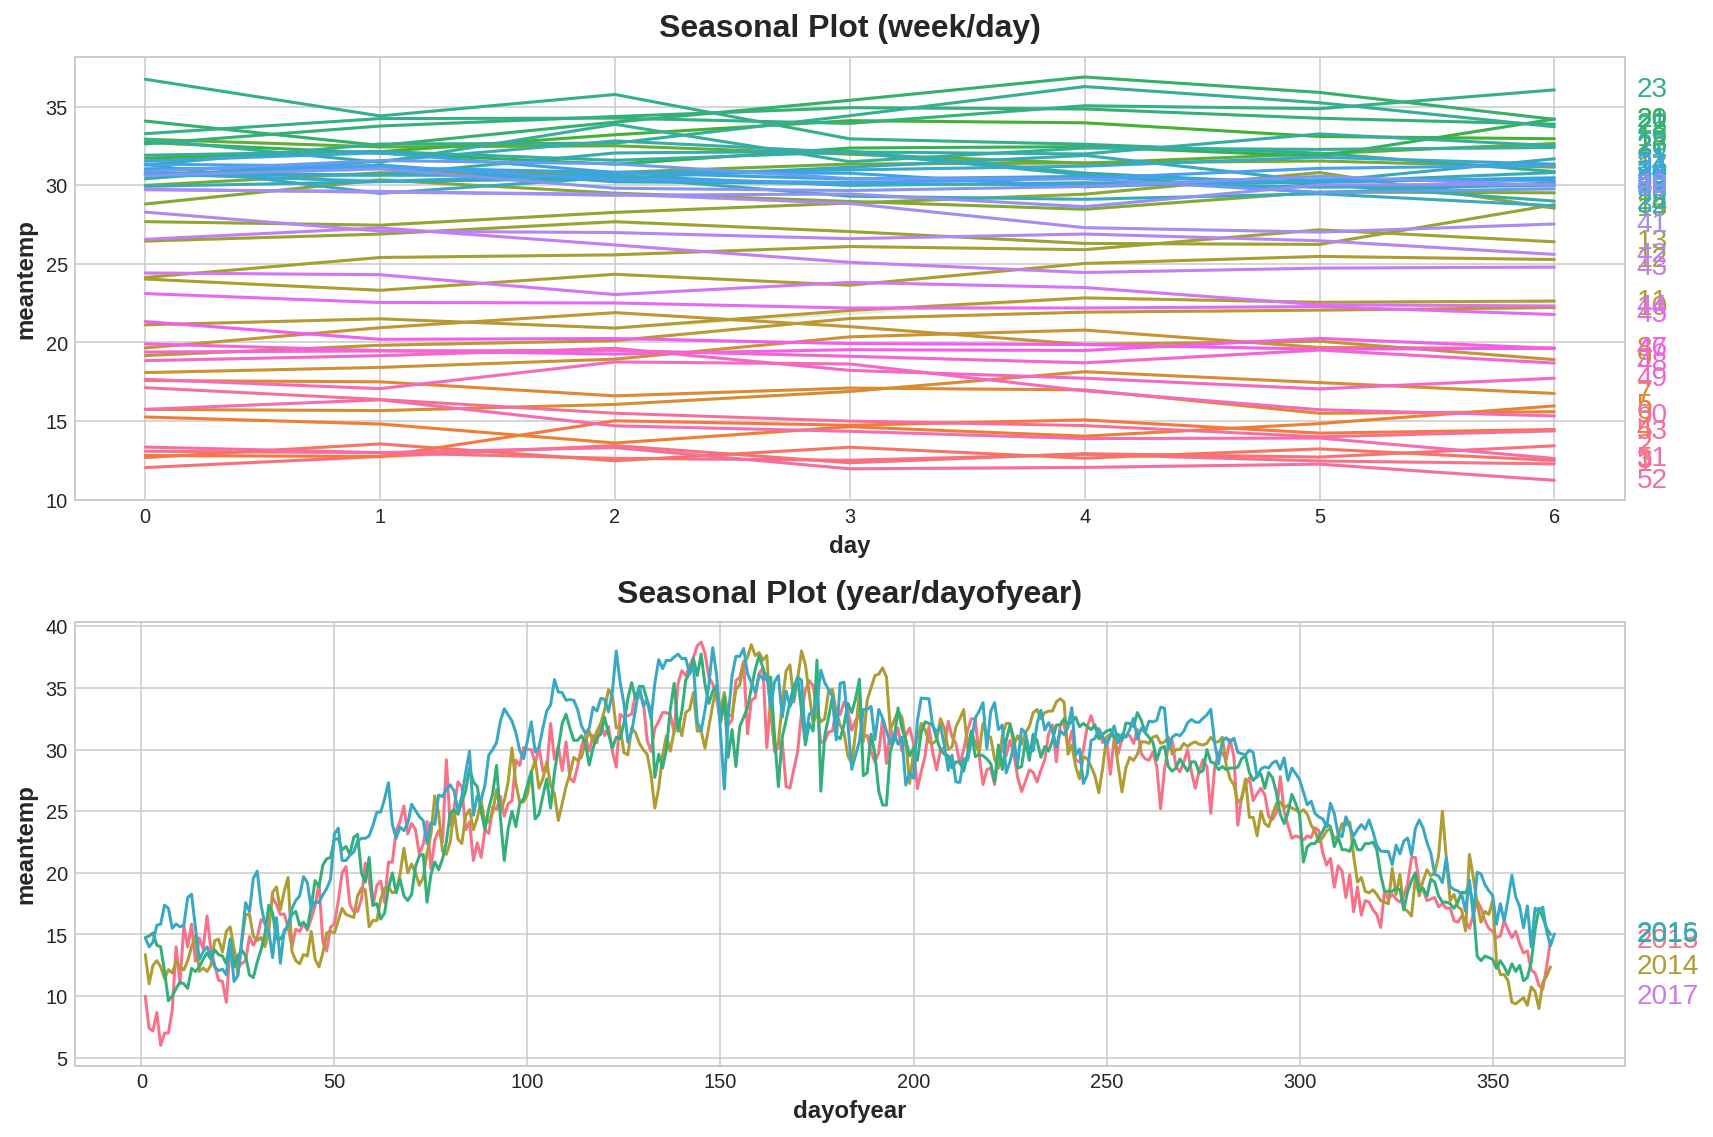

In [41]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df3, y="meantemp", period="week", freq="day", ax=ax0)
seasonal_plot(df3, y="meantemp", period="year", freq="dayofyear", ax=ax1);

La tendance 'day of year' est quasiment identique alors que pour la semaine, il y a pas vraiment de tendance

#  Utiliser les Fourier Features et analyser le périodogramme

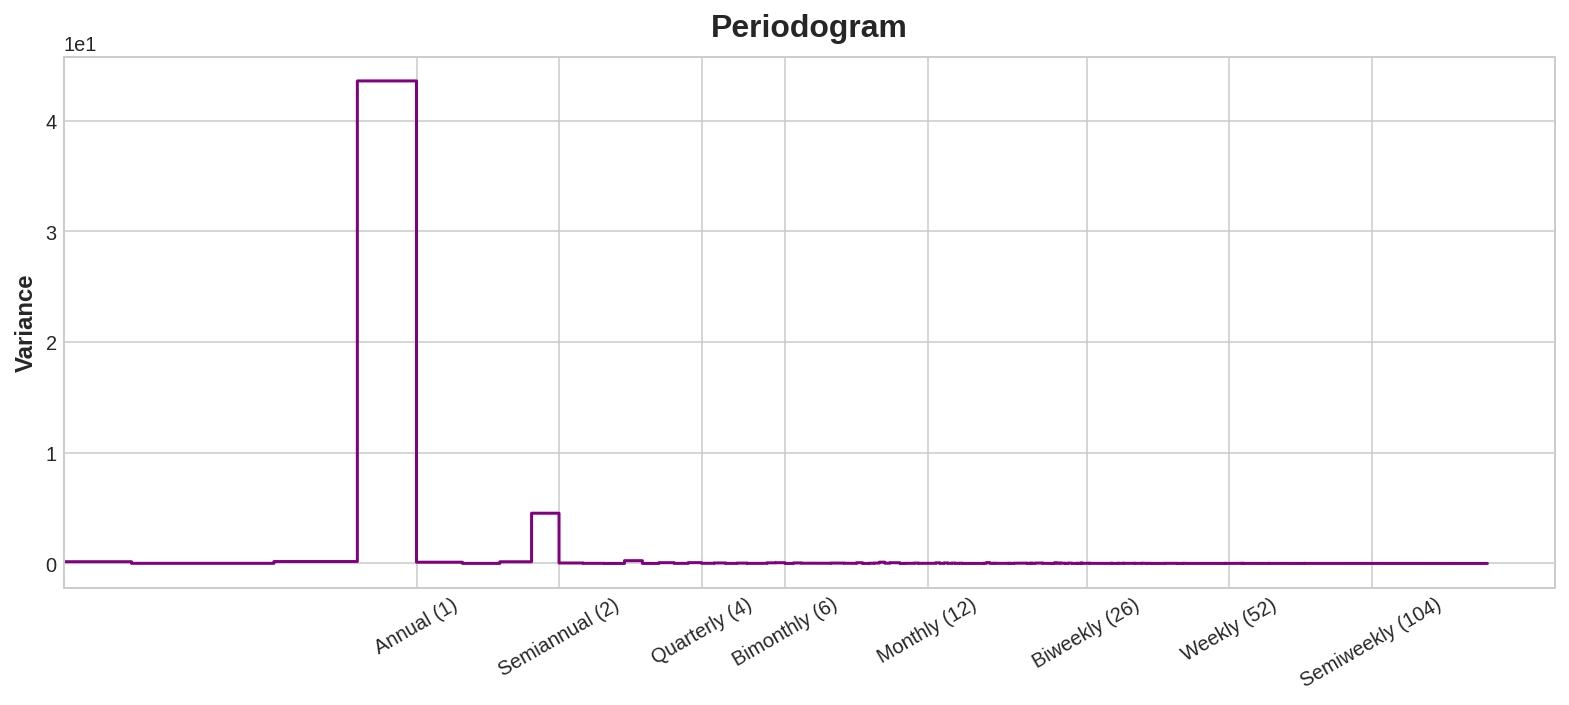

In [42]:
plot_periodogram(df3.meantemp)

La graphe est en accord avec les 2 plots journalier et hebdomadaire -> il y a une tendance annuelle et une petite tendance semiannuel mais pour le reste, rien ne resort. 

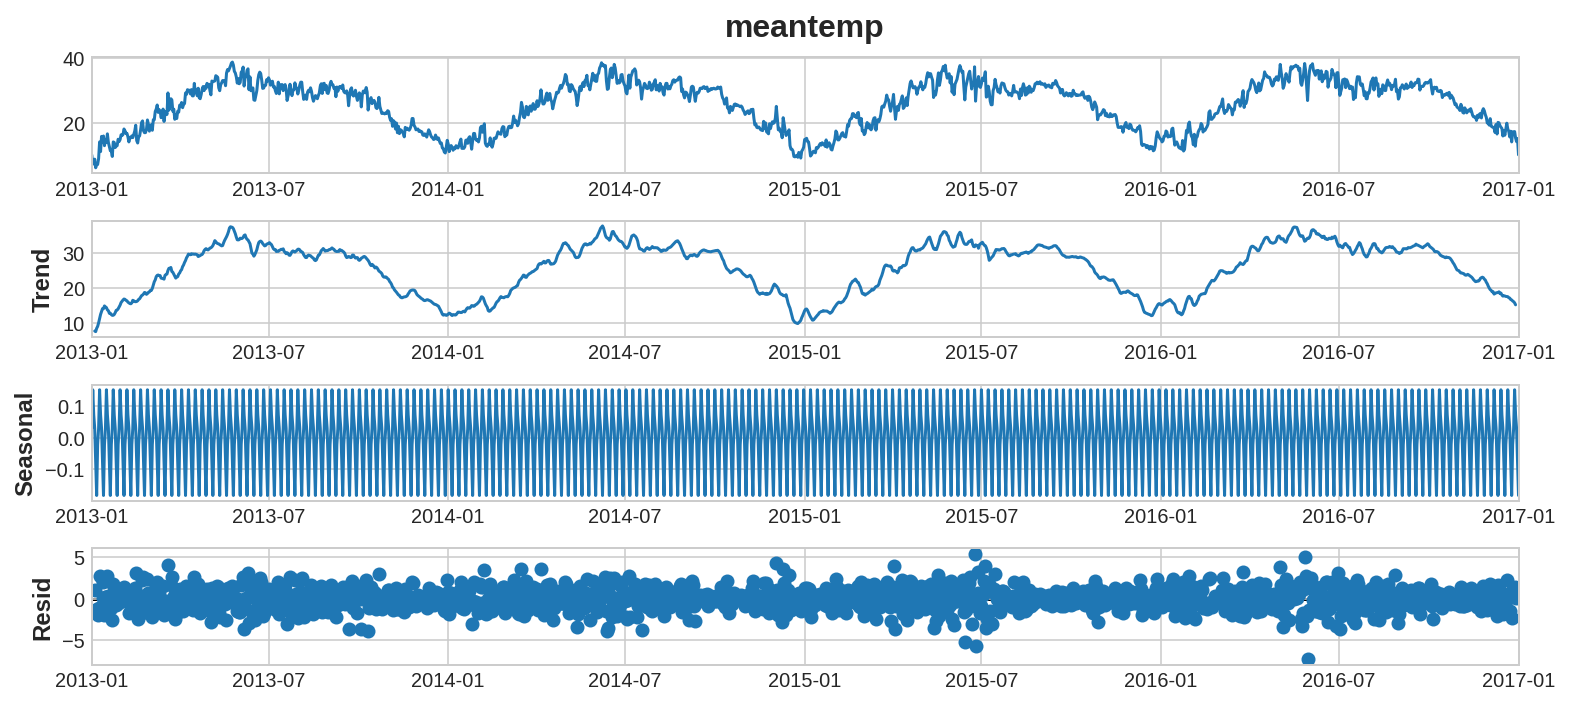

In [43]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df3.meantemp)
resplot = res.plot()
#Avec ces graphs, on peut avoir une meilleure visualisation de la saisonalité et on peut observer une tendance annuelle et semi-annuelle

# Utiliser les Deterministic Process avec le CalendarFourier afin de détecter la saisonnalité

In [44]:
index = pd.PeriodIndex(df3.index, freq='D')
df3.index = index
df3

,meantemp,day,dayofyear,week,year
date,,,,,
2013-01-01,10.000000,1,1,1,2013
2013-01-02,7.400000,2,2,1,2013
2013-01-03,7.166667,3,3,1,2013
2013-01-04,8.666667,4,4,1,2013
2013-01-05,6.000000,5,5,1,2013
...,...,...,...,...,...
2016-12-28,17.217391,2,363,52,2016
2016-12-29,15.238095,3,364,52,2016
2016-12-30,14.095238,4,365,52,2016


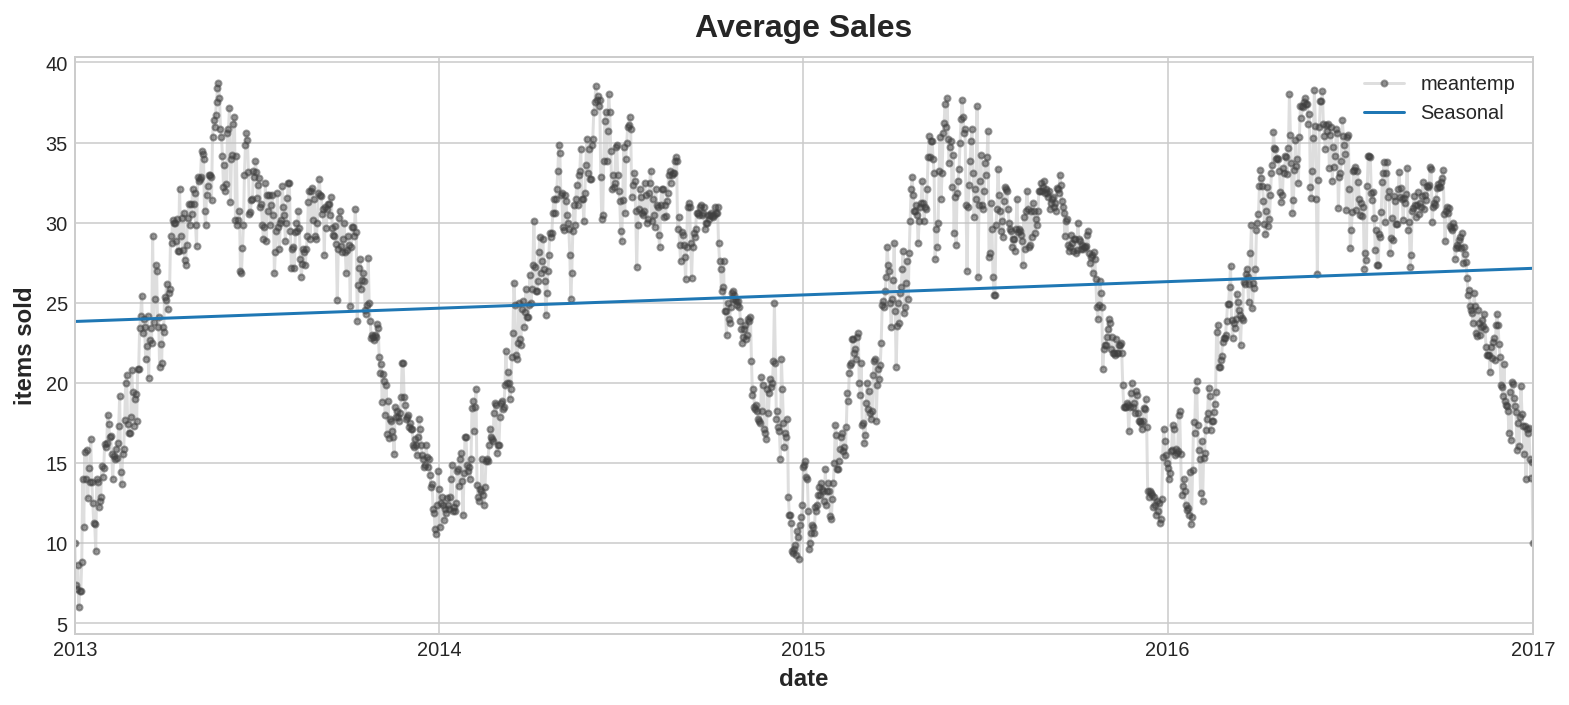

In [45]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=4)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(index=y.index, order=1)

y = df3['meantemp']
y.index=df3.index
X = dp.in_sample()
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=df3.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

# Appliquer ces méthodes sur la variable après élimination de la composante de tendance

In [46]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
df3['dayofweek']= df3.index.dayofweek
df4=df3

print(df4.index.dtype)
df3.index= df4.index
fourier = CalendarFourier(freq="A", order=1)  

dp = DeterministicProcess(
    index=df3.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
y=df3['meantemp']
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
y_deseason = y - y_pred

period[D]


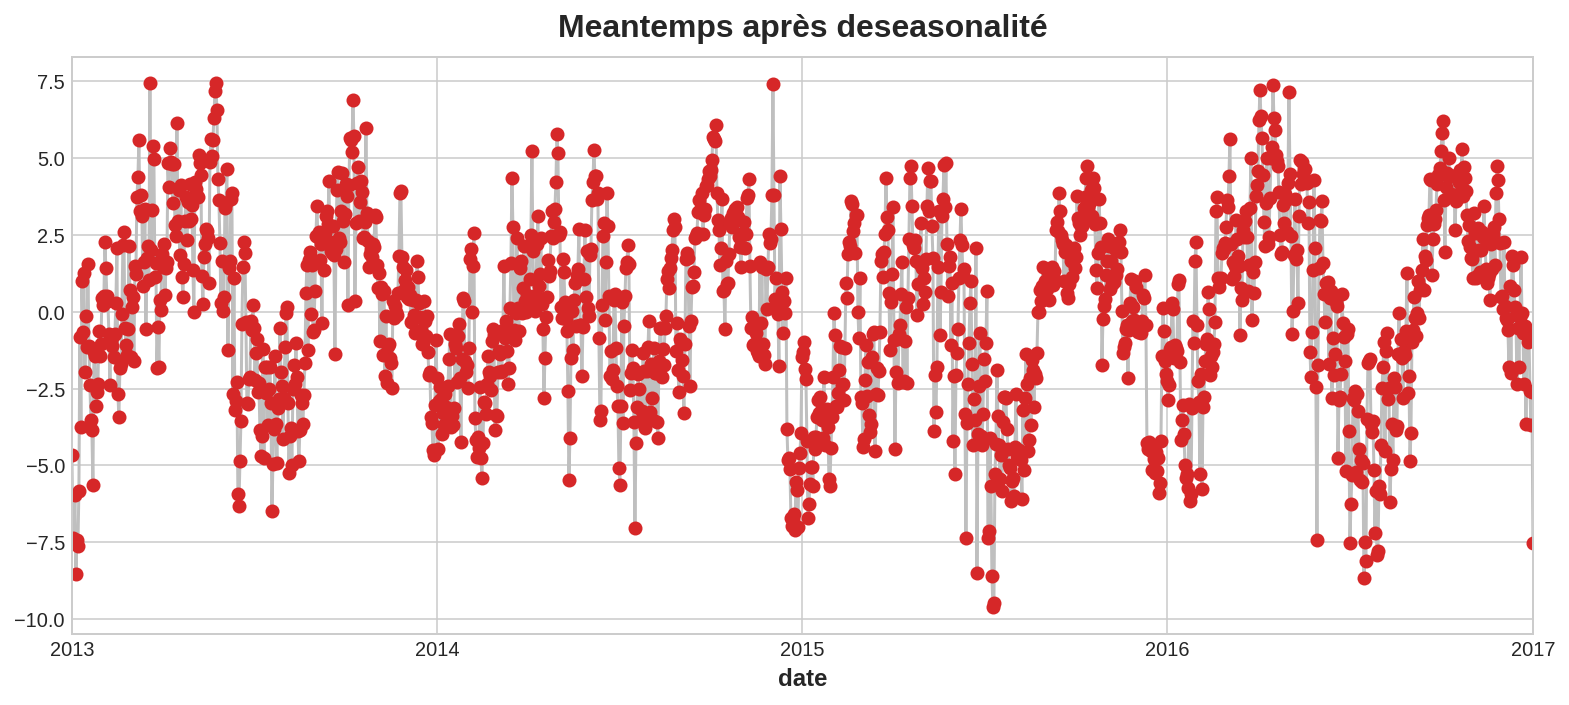

In [47]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(X.index, y_deseason[X.index], color='C3')
ax.set_title('Meantemps après deseasonalité');

# Forecast 15 jours

In [48]:
df3['dayofweek']= df3.index.dayofweek
df4=df3
#df4.index = df4.index.to_period('D')
print(df4.index.dtype)

period[D]


In [49]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
df3.index= df4.index
fourier = CalendarFourier(freq="A", order=1)  

dp = DeterministicProcess(
    index=df3.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
y=df3['meantemp']

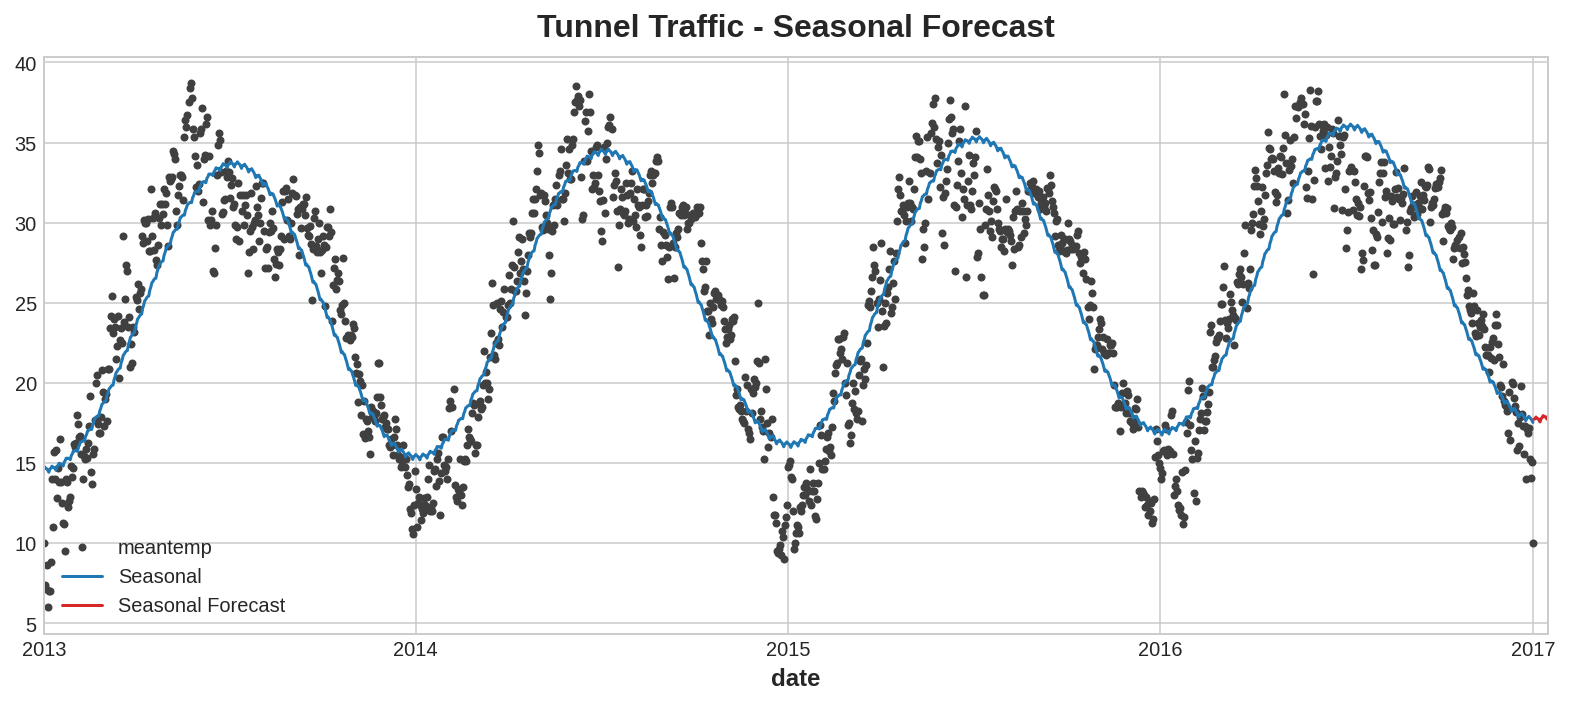

In [50]:
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=15)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Je mets egalement forecast 360 jours pour mieux visualiser

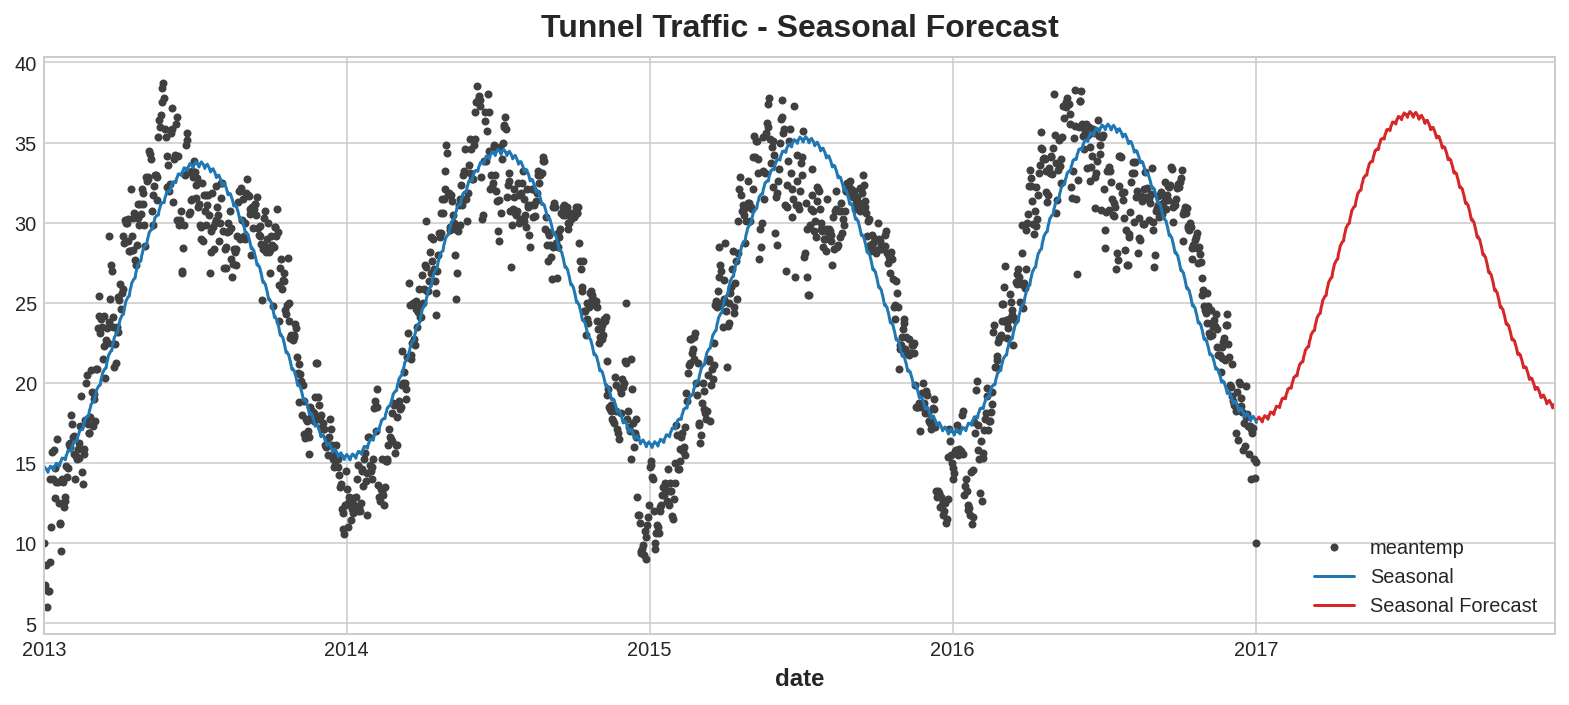

In [51]:
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=360)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

# Eliminer la saisonnalité de la composante privée de tendanc# 

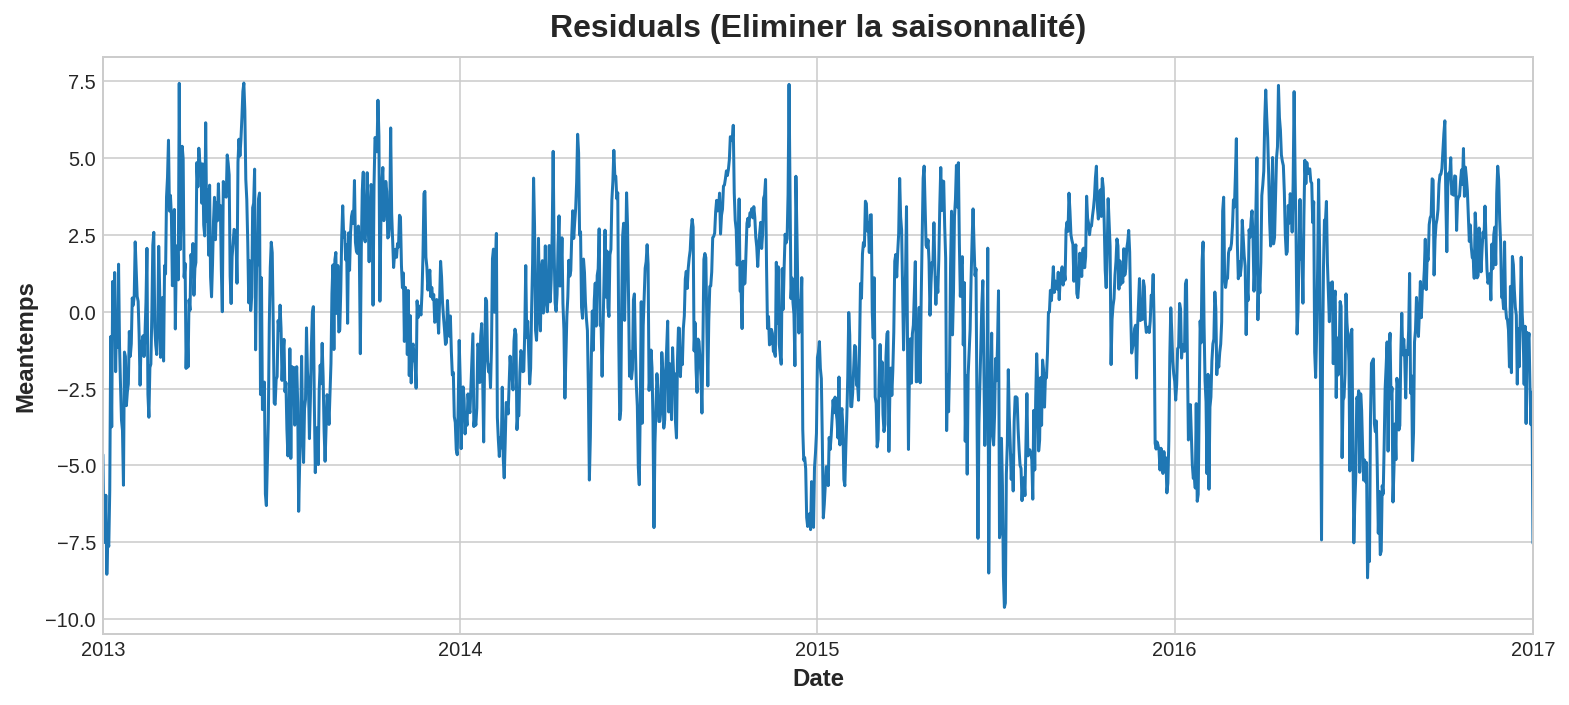

In [52]:
# calculate the residuals (i.e. remove the seasonal component from the trend component)
residuals = y - y_pred

# plot the residuals
residuals.plot(title="Residuals (Eliminer la saisonnalité)")
plt.xlabel("Date")
plt.ylabel("Meantemps")
plt.show()

# Lag features

 Tracer les courbes d’autocorrelation partielle

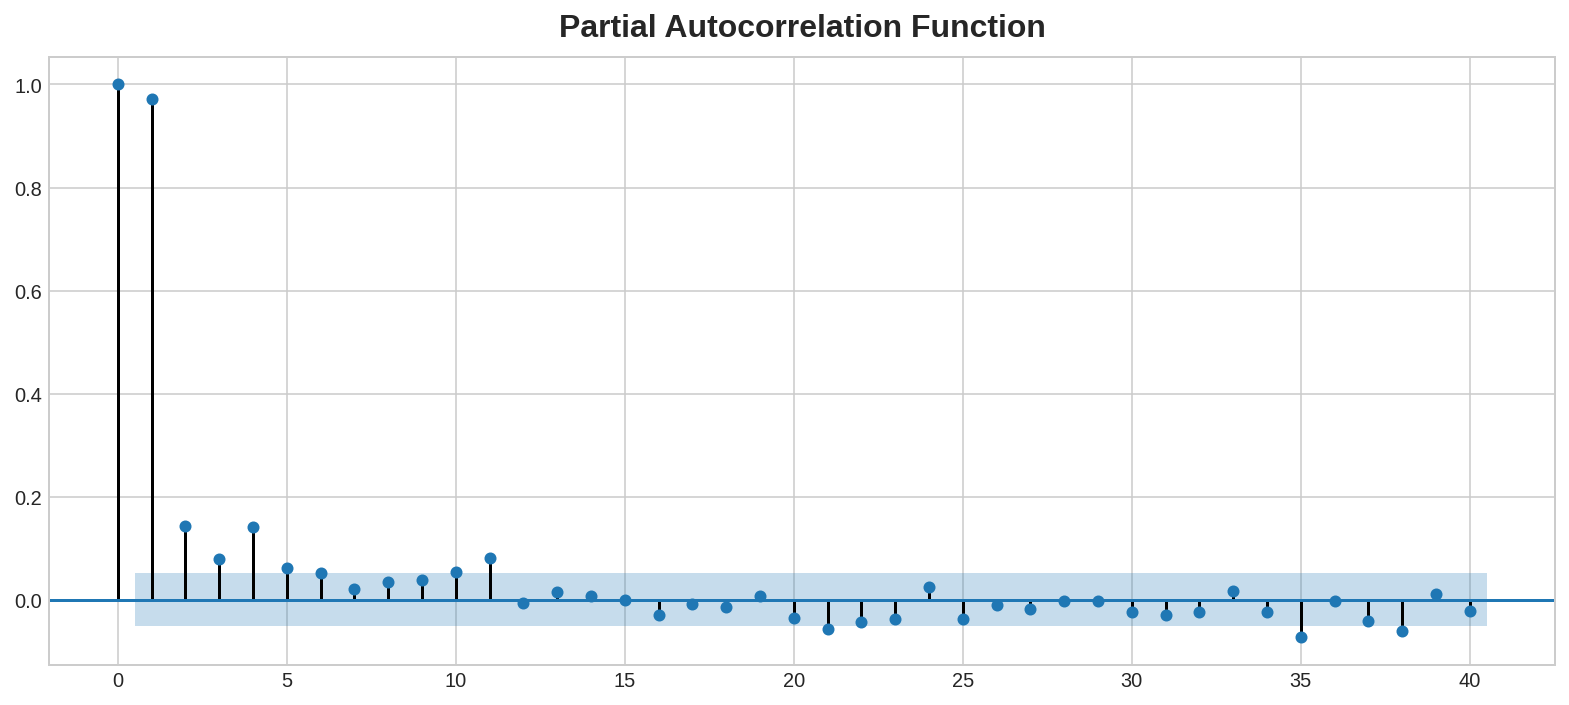

In [53]:
import statsmodels.graphics.tsaplots as tsaplots
y = df3['meantemp']
# plot the partial autocorrelation function
tsaplots.plot_pacf(y, lags=40, alpha=0.05, title="Partial Autocorrelation Function")
plt.show()


Avec ces courbes, on peut constater que les lags 1, 2, 3, 4, 5, 11 donne un niveau significatif

# Identifier les corrélations avec les Lags passés

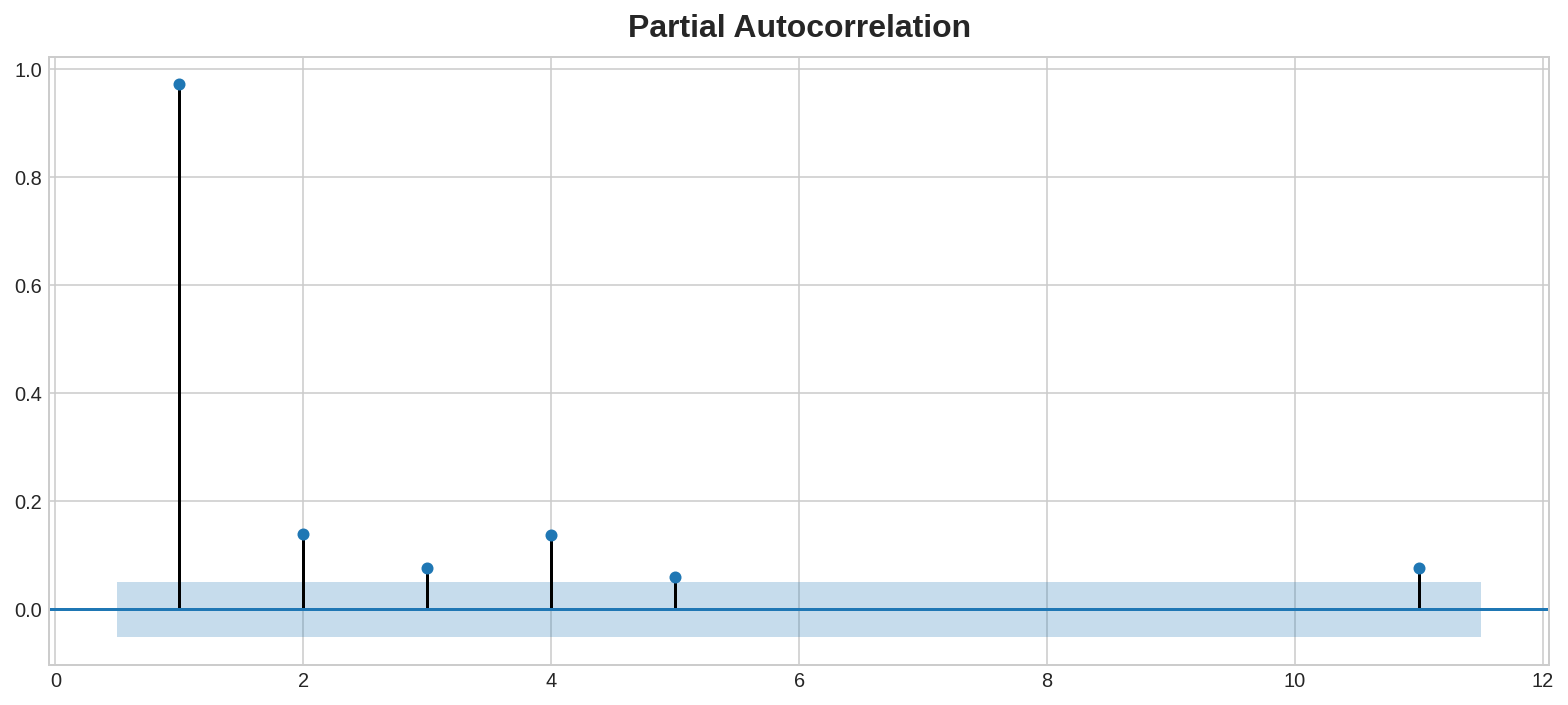

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

lags = [1, 2, 3, 4, 5, 11]  # List of desired lags
pacf = plot_pacf(df3['meantemp'], lags=lags, method='ywm')

# loop through the lagged columns and create a dot plot for each one
for i in lags:
    df3[f"lag_{i}"] = df3['meantemp'].shift(i)

# Create a 2x5 subplot grid
ncols = 2
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 12))

# flatten the 2D array of subplots
axs = axs.ravel()

# loop through the desired lags and create a dot plot for each one
for idx, i in enumerate(lags):
    sns.stripplot(data=df3, x='meantemp', y=f'lag_{i}', ax=axs[idx])
    axs[idx].set_xlabel("meantemp")
    axs[idx].set_ylabel(f"Lag {i}")
    # Calculate linear regression coefficients
    coef = np.polyfit(df3["meantemp"], df3[f"lag_{i}"], 1)
    # Plot trend line
    axs[idx].plot(df3["meantemp"], coef[0]*df3["meantemp"] + coef[1], '-r')
    
plt.show()


Avec ces 6 courbes, on peut voir que le lag 1 a la meilleure corrélation

# Analyser les cycles par le biais de Lags passés

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

lags = [1, 2, 3, 4, 5, 11] 
for lag in lags:
    X = df3.loc[:, ['lag_'+str(lag)]]
    X.dropna(inplace=True) 
    y = df3.loc[:, 'meantemp']  
    y, X = y.align(X, join='inner')  
    model = LinearRegression()
    model.fit(X, y)
    y_pred = pd.Series(model.predict(X), index=X.index)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(f'Lag {lag}: MSE={mse:.2f}, MAE={mae:.2f}')

La méthode MSE et MAE confirme que le lag 1 a le MSE et MAE les plus petits

# Faire un forecast pour 15 jours futurs

In [ ]:
df3['lag1']=df3['meantemp'].shift(1)
df3.head()

Forecast 15 jours 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df3.meantemp, lags=1)
X = X.fillna(0.0)


# Create target series and data splits
y = df3.meantemp.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=15, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

Pour mieux visualiser, je vais aussi faire 365 jours

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df3.meantemp, lags=1)
X = X.fillna(0.0)


# Create target series and data splits
y = df3.meantemp.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(y_train, y_pred)
train_mse = mean_squared_error(y_train, y_pred)

test_mae = mean_absolute_error(y_test, y_fore)
test_mse = mean_squared_error(y_test, y_fore)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)

# Soustraire les cycles de la composante sans tendance ni saisonnalité

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['meantemp'], model='multiplicative')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

detrended = data['meantemp'] - trend
deseasonalized = detrended - seasonal


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['meantemp'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# 5- Appliquer les processus hybrides

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [ ]:
y = df['meantemp']

dp = DeterministicProcess(
    index=y.index,  
    constant=True,  
    order=1,        # linear trend
    drop=True,      
)
X = dp.in_sample()  

# Split the date index

In [ ]:
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    )

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    )

In [ ]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

# Stack method

In [ ]:
X = df["meantemp"].stack()  
display(X.head())
y = X.pop('Sales')  